# Instalação de Dependências

O framework utilizado para trabalhar com as imagens foi o scikit-image.

Além disso, para facilitar a visualização e teste dos resultados a biblioteca ipywidgets também foi usada.

In [1]:
%pip install scikit-image
%pip install ipywidgets

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [17]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from ipywidgets import interact, interact_manual

# Ajuste de imagem

Para que o algoritmo funcione melhor é útil cortar a imagem apenas na região onde o cubo aparece.
Ajustar o contraste também pode ser útil para ressaltar bordas dependendo do tipo de cubo utilizado ou do ambiente onde a foto foi tirada.

In [60]:
from skimage.color import rgb2gray
from skimage.transform import resize
from skimage.exposure import rescale_intensity, equalize_hist


loaded_image = skimage.io.imread("test_images/cube_8.jpg")
cube = np.zeros_like(loaded_image)
grey_cube = rgb2gray(cube)
borders = np.zeros_like(loaded_image)
labels = np.zeros_like(loaded_image)
colors = np.zeros((9, 3, 3))


def crop_image(image, size_factor, dx=0, dy=0):
    w, h, *_ = loaded_image.shape
    size = min(w, h)
    bounding_box = (
        int((w - size * size_factor) / 2 + dy * size * (1 - size_factor)),
        int((w + size * size_factor) / 2 + dy * size * (1 - size_factor)),
        int((h - size * size_factor) / 2 - dx * size * (1 - size_factor)),
        int((h + size * size_factor) / 2 - dx * size * (1 - size_factor)),
    )

    cropped = image[
        bounding_box[0] : bounding_box[1],
        bounding_box[2] : bounding_box[3],
    ]
    cropped = resize(cropped, (512, 512), anti_aliasing=True)
    return cropped

def adjust_contrast(image, low, high):
    p_range = np.percentile(image, (low, high))
    return rescale_intensity(image, in_range=tuple(p_range))

def adjust_image(size_factor=1, dx=0, dy=0, low_percentil=2, high_percentil=98):
    global cube
    global grey_cube

    cube = loaded_image.copy()
    cube = crop_image(cube, size_factor, dx, dy)
    cube = adjust_contrast(cube, low_percentil, high_percentil)
    grey_cube = 1 - rgb2gray(cube)

    plt.imshow(cube)
    plt.show()

interact(adjust_image, 
         size_factor=(0.1, 1, 0.01), 
         dx = (-1, 1, 0.01),
         dy = (-1, 1, 0.01),
         low_percentil = (0, 100),
         high_percentil = (0, 100),
)

interactive(children=(FloatSlider(value=1.0, description='size_factor', max=1.0, min=0.1, step=0.01), FloatSli…

<function __main__.adjust_image(size_factor=1, dx=0, dy=0, low_percentil=2, high_percentil=98)>

# Extração de bordas

O primeiro passo do método é extrair as bordas da imagem utilizando o algoritmo Canny.
Neste passo é possível contornar algumas falhas na extração de borda através do algoritmo de fechamento.

In [61]:
from skimage.feature import canny
from skimage.morphology import binary_dilation, binary_closing, thin
from skimage.morphology import disk, star


def extract_borders(image, sigma, closing):
    borders = canny(image, sigma, low_threshold=0)
    closing = binary_closing(borders, star(closing))
    skeleton = thin(closing)
    dilated = binary_dilation(skeleton, disk(2))
    return dilated

def show_borders(sigma=1, closing=1):
    global grey_cube
    global borders

    borders = extract_borders(grey_cube, sigma, closing)
    plt.imshow(cube)
    plt.imshow(borders, alpha=(borders == 1) * 0.9)
    plt.show()

interact(show_borders, sigma=(0, 5, 0.01), closing=(1, 10))

interactive(children=(FloatSlider(value=1.0, description='sigma', max=5.0, step=0.01), IntSlider(value=1, desc…

<function __main__.show_borders(sigma=1, closing=1)>

# Extração dos quadrados

Para extrair os quadrados utilizamos as bordas detectadas no passo anterior e separamos cada área delimitada por elas.

Nem todas as regiões extraidas são de nosso interesse, por isso filtramos as regiões desejadas de acordo com:
- A área ocupada pela região;
- A solidez da região.

Neste momento espera-se que a imagem resultante contenha apenas 27 regiões. 9 Para cada uma das faces visíveis.

In [62]:
from skimage import measure
from skimage.color import label2rgb


def extract_labels(borders, min_area, max_area, min_solidity):
    labels, num_labels = ndimage.label(borders == 0)
    props = measure.regionprops(labels)

    for i in range(1, num_labels+1):
        current_label = (labels == i)
        area = props[i - 1].area
        solidity = props[i - 1].solidity

        if solidity < min_solidity:
            labels[current_label] = 0

        elif not (min_area**2 < area < max_area**2):
            labels[current_label] = 0

    labels, num_labels = ndimage.label(labels)
    return labels, num_labels

def show_labels(min_area=20, max_area=512, min_solidity=0.8):
    global cube
    global borders
    global labels
    
    labels, num_labels = extract_labels(borders, min_area, max_area, min_solidity)

    print(f"Partes encontradas: {num_labels}/27")

    plt.imshow(label2rgb(labels))
    plt.show()

interact(show_labels, min_area=(0, 100), max_area=(0, 512), min_solidity=(0, 1, 0.01))

interactive(children=(IntSlider(value=20, description='min_area'), IntSlider(value=512, description='max_area'…

<function __main__.show_labels(min_area=20, max_area=512, min_solidity=0.8)>

# Identificação dos quadrados e rotulação

Até o momento todas as transformações feitas foram do tipo Imagem -> Imagem.
Este passo começa a transformar os resultados obtidos da imagem em um modelo.

Esta etapa contém os seguintes passos:
- Extração do casco convexo (para contornar problemas da segmentação)
- Extração dos principais eixos de cada quadrado
- Transformação do centro de cada quadrado para o sistema de coordenadas de sua face
- Ordenação das coordenadas locais por face da esquerda para a direita e de cima para baixo
- União dos índices de cada face
- Criação de um novo conjunto de labels com índices ordenados

Este método ainda não funciona bem quando menos faces estão visíveis devido ao arredondamento irresponsável dos ângulos.

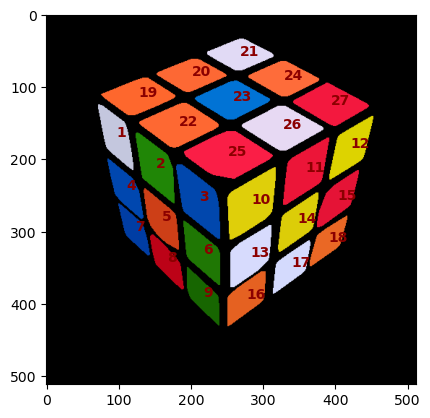

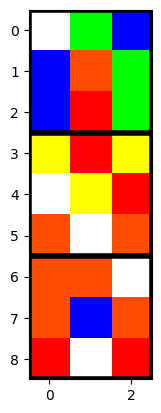

In [63]:
from skimage.morphology import dilation, convex_hull_image
from skimage.transform import hough_line, hough_line_peaks
from skimage import measure
from collections import defaultdict


def find_main_angles(image):
    partial_borders = dilation(image) ^ image

    hspace, angles, distances = hough_line_peaks(
        *hough_line(partial_borders),
        num_peaks=4,
        min_distance=20,
    )

    # Só estou interessado em alguns poucos ângulos específicos
    # por isso estou arredondando e retornando na ordem que é mais
    # conveniente pra mim.

    rounded_angles = set(np.round(angles))
    if (-1 in rounded_angles) and (1 in rounded_angles):
        x = np.pi / 4
        y = -np.pi / 4

    elif (0 in rounded_angles) and (1 in rounded_angles):
        x = np.pi / 4
        y = 0

    elif (0 in rounded_angles) and (-1 in rounded_angles):
        x = np.pi * 3 / 4
        y = 0
    
    else:
        x = 0
        y = 0
    
    return x, y


def find_base_transformation(x_angle, y_angle):
    x_hat = np.array([np.cos(x_angle), -np.sin(x_angle)])
    x_hat = x_hat / np.linalg.norm(x_hat)

    y_hat = np.array([np.cos(y_angle), -np.sin(y_angle)])
    y_hat = y_hat / np.linalg.norm(y_hat)

    canonical_to_current = np.column_stack([x_hat, y_hat])
    current_to_canonical = np.linalg.inv(canonical_to_current)

    return current_to_canonical


def sort_face(label_vals, positions):
    if len(label_vals) != 9:
        return []

    x_array = np.array([positions[i][0] for i in label_vals])
    y_array = np.array([positions[i][1] for i in label_vals])

    sorted_x_indexes = np.argsort(x_array)
    sorted_by_x = np.array(label_vals)[sorted_x_indexes].reshape(3, 3)

    y_array = y_array[sorted_x_indexes].reshape(3, 3)
    sorted_y_indexes = np.argsort(y_array, axis=1)
    sorted_by_y = np.take_along_axis(sorted_by_x, sorted_y_indexes, axis=1)
    sorted_by_y = np.flip(sorted_by_y, axis=1)

    return sorted_by_y.flatten()


def reorder_labels(labels):
    label_indexes = np.unique(labels)
    convex_labels = labels.copy()
    props = measure.regionprops(labels)

    for index in label_indexes:
        if index == 0:
            continue
        current_label = (labels == index)
        convex_labels[convex_hull_image(current_label)] = index

    grouped_by_faces = defaultdict(list)
    local_coordinates_face = dict()
    for index in label_indexes:
        if index == 0:
            continue

        current_label = (convex_labels == index)
        xa, ya = find_main_angles(current_label)
        centroid = props[index - 1].centroid
        grouped_by_faces[xa, ya].append(index)

        try:
            transformation = find_base_transformation(xa, ya)
            y, x = transformation @ centroid
            local_coordinates_face[index] = (x, y)
        except:
            continue
    
    counter = 1
    order_translator = dict()

    # bla is here just to reinforce the iteration order
    for bla, group in sorted(grouped_by_faces.items(), reverse=True):
        for i in sort_face(group, local_coordinates_face):
            order_translator[i] = counter
            counter += 1

    reordered_labels = np.zeros_like(convex_labels)
    for index in label_indexes:
        if index == 0:
            continue
        current_label = (convex_labels == index)
        reordered_labels[current_label] = order_translator.get(index, 0)

    return reordered_labels, len(label_indexes) - 1

def round_to_common_colors(array):
    red = (1, 0, 0)
    green = (0, 1, 0)
    blue = (0, 0, 1)
    white = (1, 1, 1)
    yellow = (1, 1, 0)
    orange = (1, 0.3, 0)
    common_colors = np.array([red, green, blue, white, yellow, orange])

    rounded = []
    for color in array:
        euclidean_distances = [np.linalg.norm(color - common_color) for common_color in common_colors]
        best_index = np.argmin(euclidean_distances)
        rounded.append(common_colors[best_index])
    return np.array(rounded)

    # plt.imshow(common_colors)
    # plt.show()

    # for line in array:
    #     for color in line:
    #         print(color)


def show_ordered_labels():
    global labels
    global colors 

    reordered_labels, num_labels = reorder_labels(labels)

    plt.imshow(label2rgb(reordered_labels, cube, kind="avg"))
    for index in range(1, num_labels+1):
        if index == 0:
            continue
        current_label = (reordered_labels == index)
        centroid = measure.centroid(current_label)
        y, x = centroid
        plt.text(x, y, index, color="darkred", fontweight="bold")
    plt.show()

    props = measure.regionprops(reordered_labels, intensity_image=cube)
    colors = np.array([prop.mean_intensity for prop in props])
    colors = round_to_common_colors(colors)
    colors = colors.reshape(3, 9, 3)
    plt.imshow(colors.reshape(9, 3, 3))

    plt.hlines(-0.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
    plt.hlines(2.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
    plt.hlines(5.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
    plt.hlines(8.5, xmin=-0.5, xmax=2.5, color="black", linewidth=4)
    plt.vlines(-0.5, ymin=-0.5, ymax=8.5, color="black", linewidth=4)
    plt.vlines(2.5, ymin=-0.5, ymax=8.5, color="black", linewidth=4)
    plt.show()

show_ordered_labels()

[[1.  1.  1. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [0.  0.  1. ]
 [1.  0.3 0. ]
 [0.  1.  0. ]
 [0.  0.  1. ]
 [1.  0.  0. ]
 [0.  1.  0. ]
 [1.  1.  0. ]
 [1.  0.  0. ]
 [1.  1.  0. ]
 [1.  1.  1. ]
 [1.  1.  0. ]
 [1.  0.  0. ]
 [1.  0.3 0. ]
 [1.  1.  1. ]
 [1.  0.3 0. ]
 [1.  0.3 0. ]
 [1.  0.3 0. ]
 [1.  1.  1. ]
 [1.  0.3 0. ]
 [0.  0.  1. ]
 [1.  0.3 0. ]
 [1.  0.  0. ]
 [1.  1.  1. ]
 [1.  0.  0. ]]


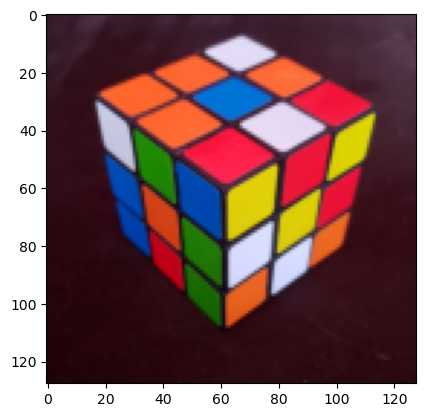

In [71]:
import h5py
from skimage.transform import resize


def append_to_dataset(dataset, x, y):
    plt.imshow(x)
    print(y)

with h5py.File("hello.hdf5", "a") as file:
    x = resize(cube, (128, 128))
    y = colors.reshape(-1, 3)
    append_to_dataset(file, x, y)

# https://stackoverflow.com/questions/47072859/how-to-append-data-to-one-specific-dataset-in-a-hdf5-file-with-h5py
# pra não peder
